In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys

sys.path.append("../EDA")
DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005

import movie_data_formatter as mdf
import movie_rating_gender as mrgy
import general_functions as gf

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_table(df)
processed_data = mrgy.reformat_gender_identity(processed_data)
df_gender = processed_data[processed_data['gender_identity'].isin(['Male', 'Female'])].dropna(subset=['rating'])



# Question 4
What proportion of movies are rated differently by male and female viewers?


We now want to know how many movies show a statistically significant difference between male and female average ratings. 

The procedure to answer this question is as followed: 
1. Compare female and male 
2. Test their median or mean 
3. Count number of movies such that p < 0.005
4. Divide by the total of movies to calculate the proportion.

In [2]:
df_gender.head()

,report_id,movie_name,rating,year,tends_to_find_fault_with_others,does_a_thorough_job,is_depressedblue,is_originalcomes_up_with_new_ideas,is_reserved,is_helpful_and_unselfish_with_others,...,i_like_to_be_surprised_even_if_it_startles_or_scares_me,have_you_ever_parachuted,i_enjoy_haunted_houses,i_had_a_sheltered_upbringing,my_life_is_very_stressful,i_value_my_life_to_be_well_ordered_and_predictable,have_you_ridden_a_motorcycle,have_you_gambled_or_bet_for_money,have_you_ever_been_skydiving,is_talkative
2,1.0,Django Unchained,4.0,2012,2.0,NaN,4.0,4.0,5.0,2.0,...,5.0,1.0,1.0,1.0,2.0,3.0,2.0,2.0,1.0,1.0
4,1.0,Indiana Jones and the Last Crusade,3.0,1989,2.0,NaN,4.0,4.0,5.0,2.0,...,5.0,1.0,1.0,1.0,2.0,3.0,2.0,2.0,1.0,1.0
14,1.0,The Fast and the Furious,4.0,2001,2.0,NaN,4.0,4.0,5.0,2.0,...,5.0,1.0,1.0,1.0,2.0,3.0,2.0,2.0,1.0,1.0
17,1.0,Psycho,3.5,1960,2.0,NaN,4.0,4.0,5.0,2.0,...,5.0,1.0,1.0,1.0,2.0,3.0,2.0,2.0,1.0,1.0
29,1.0,The Karate Kid Part II,3.5,1986,2.0,NaN,4.0,4.0,5.0,2.0,...,5.0,1.0,1.0,1.0,2.0,3.0,2.0,2.0,1.0,1.0


In [3]:
df_gender_movie = df_gender.groupby(['movie_name'])
n_movies = len(df_gender_movie)

mann_whitney_results = {}
welch_ttest_results = {}

for name, group in df_gender_movie:
    movie_name = name
    # drop NA ratings
    ratings = group['rating'].dropna()
    
    # Split ratings by gender
    male_ratings = ratings[group['gender_identity'] == 'Male']
    female_ratings = ratings[group['gender_identity'] == 'Female']
    
    if len(male_ratings) > 0 and len(female_ratings) > 0:
        # Mann-Whitney U Test
        u_stat, p_value_mw = stats.mannwhitneyu(male_ratings, female_ratings, alternative='two-sided')
        mann_whitney_results[movie_name] = p_value_mw
        
        # Welch's t-test
        t_stat, p_value_wt = stats.ttest_ind(male_ratings, female_ratings, equal_var=False, alternative='two-sided')
        welch_ttest_results[movie_name] = p_value_wt
        
significant_mw = {movie: p for movie, p in mann_whitney_results.items() if p < ALPHA}
significant_wt = {movie: p for movie, p in welch_ttest_results.items() if p < ALPHA}


In [4]:
# plot the p-value distributions
df_mann_whitney = pd.DataFrame.from_dict(mann_whitney_results, orient='index', columns=['p_value'])
df_welch_ttest = pd.DataFrame.from_dict(welch_ttest_results, orient='index', columns=['p_value'])

# join the two dataframes for comparison
df_pvalues = df_mann_whitney.join(df_welch_ttest, lsuffix='_mann_whitney', rsuffix='_welch_ttest')
   

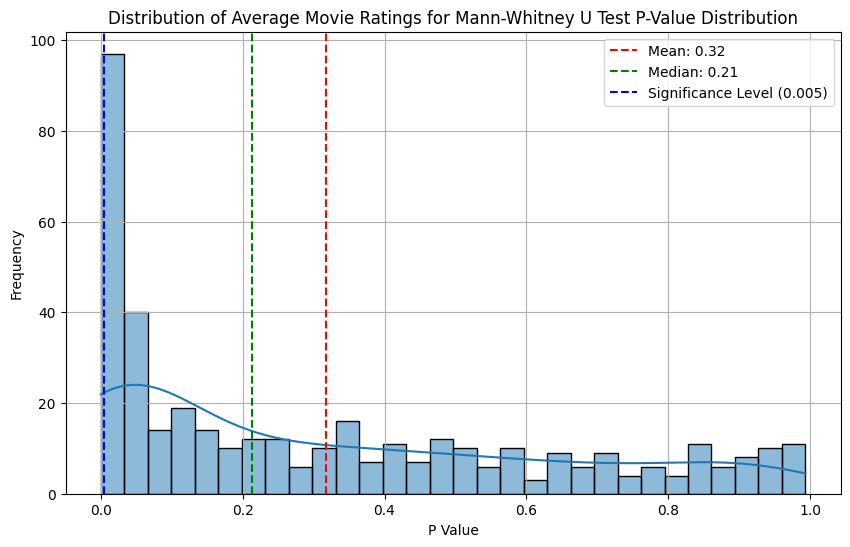

In [5]:
plt = gf.plot_distrubtion(df_mann_whitney, 
    name='Mann-Whitney U Test P-Value Distribution', 
    y ='p_value',
    show=False)

plt.axvline(x=0.005, color='b', linestyle='--', label='Significance Level (0.005)')
plt.legend()

plt.show()

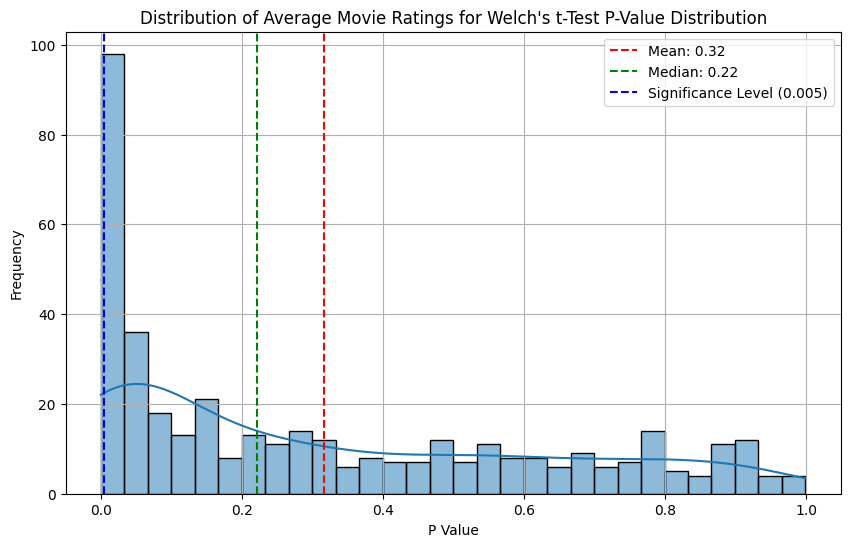

In [6]:
plt = gf.plot_distrubtion(df_welch_ttest,
    name='Welch\'s t-Test P-Value Distribution', 
    y ='p_value',
    show=False)

# show the p-value = 0.005 line
plt.axvline(x=0.005, color='b', linestyle='--', label='Significance Level (0.005)')
plt.legend()

plt.show()

In [7]:
df_pvalues['proportion_mw_significant'] = (df_pvalues['p_value_mann_whitney'] < ALPHA).astype(int)
df_pvalues['proportion_welch_significant'] = (df_pvalues['p_value_welch_ttest'] < ALPHA).astype(int)

proportion_mw_significant = df_pvalues['proportion_mw_significant'].mean()
proportion_welch_significant = df_pvalues['proportion_welch_significant'].mean()

print(f"Proportion of movies with significant gender rating differences (Mann-Whitney U Test): {proportion_mw_significant:.4f}")
print(f"Proportion of movies with significant gender rating differences (Welch's t-Test): {proportion_welch_significant:.4f}")


Proportion of movies with significant gender rating differences (Mann-Whitney U Test): 0.1250
Proportion of movies with significant gender rating differences (Welch's t-Test): 0.1125


In [8]:
# what movies are significant according to both tests?
significant_both = set(significant_mw.keys()).intersection(set(significant_wt.keys()))
print(f"Movies significant in both tests: {significant_both}")
print(f"Number of movies significant in both tests: {len(significant_both)}")

Movies significant in both tests: {("Harry Potter and the Sorcerer's Stone",), ('Harry Potter and the Chamber of Secrets',), ('My Big Fat Greek Wedding',), ('Beauty and the Beauty',), ('The Thing',), ('Uptown Girls',), ('The Proposal',), ('Batman: The Dark Knight',), ('The Holiday',), ('The Exorcist',), ('Clueless',), ('Django Unchained',), ('Gladiator',), ('The Lost World: Jurassic Park',), ('Bend it Like Beckham',), ('Harry Potter and the Goblet of Fire',), ('The Firm',), ('13 Going on 30',), ('Divine Secrets of the Ya-Ya Sisterhood',), ('Inglorious Bastards',), ('Cheaper by the Dozen',), ('8 Mile',), ('The Matrix',), ("Can't Hardly Wait",), ('Harry Potter and the Deathly Hallows: Part 2',), ('Transformers: Age of Extinction',), ('Grease',), ('Star Wars: Episode IV - A New Hope',), ('Apocalypse Now',), ('Funny Girl',), ('Chicago',), ('Inception',), ('Knight and Day',), ('Andaz Apna Apna',), ('The Wolf of Wall Street',), ('Alien',), ('Girl Interrupted',), ('The Cabin in the Woods',), 

In [9]:
# what movies are significant according to only one test?
significant_only_mw = set(significant_mw.keys()).difference(set(significant_wt.keys()))
print(f"Movies significant only in Mann-Whitney U Test: {significant_only_mw}")
print(f"Number of movies significant only in Mann-Whitney U Test: {len(significant_only_mw)}")


Movies significant only in Mann-Whitney U Test: {('Die Hard',), ('Indiana Jones and the Raiders of the Lost Ark',), ('Elf',), ('Room',), ('Fargo',), ("Pirates of the Caribbean: Dead Man's Chest",), ('Iron Man 3',)}
Number of movies significant only in Mann-Whitney U Test: 7


In [10]:
significant_only_wt = set(significant_wt.keys()).difference(set(significant_mw.keys()))
print(f"Movies significant only in Welch's t-Test: {significant_only_wt}")
print(f"Number of movies significant only in Welch's t-Test: {len(significant_only_wt)}")

Movies significant only in Welch's t-Test: {('Grown Ups 2',), ('Terminator 2: Judgement Day',)}
Number of movies significant only in Welch's t-Test: 2
